In [1]:
from sdia import *
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix

import pandas as pd
import matplotlib.pyplot as plt

import pymzml as pml
from pyopenms import *

from tqdm import tqdm

### Data

In [3]:
slib = SpectralLibrary.from_csv("../Data/spectral_library/filtered_silac_library_b&y", is_silac=True)
slib.library = slib.library.drop_duplicates(subset=["isotope", "name"], keep=False)

decoy_lib = SpectralLibrary.from_csv("../Data/spectral_library/filtered_silac_library_b&y_DECOY", is_silac=True)
decoy_lib.library = decoy_lib.library.drop_duplicates(subset=["isotope", "name"], keep=False)

For now, I need to extract relevant info but this will be redesigned later.

In [5]:
%%time
meta = slib.meta
peptide_dict = {name: ind for ind, name in enumerate(slib.meta.index)}
isotope_dict = {name: ind for ind, name in enumerate(slib.meta.isotope)}
meta_peptide = np.array([peptide_dict[name] for name in slib.meta.index])
meta_isotope = np.array([isotope_dict[name] for name in slib.meta.isotope])

spec_peptide = np.array([peptide_dict[name] for name in slib.library.index])
spec_isotope = np.array([isotope_dict[name] for name in slib.library.isotope])
spec_mz = slib.library.mz.values
spec_intensity = slib.library.intensity.values

decoy_meta = decoy_lib.meta
decoy_peptide_dict = {name: ind for ind, name in enumerate(decoy_lib.meta.index)}
decoy_isotope_dict = {name: ind for ind, name in enumerate(decoy_lib.meta.isotope)}
decoy_meta_peptide = np.array([decoy_peptide_dict[name] for name in decoy_lib.meta.index])
decoy_meta_isotope = np.array([decoy_isotope_dict[name] for name in decoy_lib.meta.isotope])

decoy_spec_peptide = np.array([decoy_peptide_dict[name] for name in decoy_lib.library.index])
decoy_spec_isotope = np.array([decoy_isotope_dict[name] for name in decoy_lib.library.isotope])
decoy_spec_mz = decoy_lib.library.mz.values
decoy_spec_intensity = decoy_lib.library.intensity.values

CPU times: user 636 ms, sys: 9 ms, total: 645 ms
Wall time: 646 ms


In [6]:
msrun = pml.run.Reader("../Data/DIA_FULL/UWPROFL0362.mzML")

In [7]:
file = MzMLFile()
exp = MSExperiment()
filename_in = "../Data/DIA_FULL/UWPROFL0362.mzML"
file.load(filename_in, exp)

### Analysis

#### Step 1. Extract MS2 spectra from run

In [8]:
frame_ind = 30060
frame = exp[frame_ind]
print("MS Level:", frame.getMSLevel())

pre = frame.getPrecursors()[0]
low_window, high_window = pre.getMZ() + pre.getIsolationWindowLowerOffset() * np.array([-1. , 1.])
print("Isolation Window: {} - {}".format(low_window, high_window))

print("Retention:", frame.getRT())

MS Level: 2
Isolation Window: 610.559997558594 - 630.559997558594
Retention: 2677.358547777


#### Step 2. Create bins at a certain error

In [9]:
ppm_error = 5.
mz, intensity = frame.get_peaks()
mass_window = ppm_error * mz * 1e-6 
overlapping_peaks = np.searchsorted(mz + mass_window, mz - mass_window)
unique_overlapping = np.unique(overlapping_peaks)
if unique_overlapping.shape[0] != overlapping_peaks.shape[0]:
    mz = np.array(
        [np.mean(mz[np.where(overlapping_peaks == i)]) for i in unique_overlapping]
    )
    intensity = np.array(
        [np.sum(intensity[np.where(overlapping_peaks == i)]) for i in unique_overlapping]
    )

mass_window = ppm_error * mz * 1e-6
intervals = np.sort(np.concatenate([mz - mass_window, mz + mass_window]))

#### Step 3. Filter spectra down

In [66]:
%time
low_rt, high_rt = frame.getRT() + 60 * 5. * np.array([-1., 1.])
retention_select = np.searchsorted(np.array([low_rt, high_rt]), meta.retention.values) == 1

pre = frame.getPrecursors()[0]
low_window, high_window = pre.getMZ() + pre.getIsolationWindowLowerOffset() * np.array([-1. , 1.])
window_select = np.searchsorted(np.array([low_window, high_window]), meta.precursor) == 1

select = np.logical_and(retention_select, window_select)

relevant_meta = meta[select]

relevant_mz = spec_mz[select[spec_isotope]]
relevant_intensity = spec_intensity[select[spec_isotope]]
relevant_isotope = spec_isotope[select[spec_isotope]]

print(low_rt, high_rt)
print(low_window, high_window)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs
2377.358547777 2977.358547777
610.559997558594 630.559997558594


In [11]:
low_rt, high_rt = frame.getRT() + 60 * 5. * np.array([-1., 1.])
decoy_retention_select = np.searchsorted(np.array([low_rt, high_rt]), decoy_meta.retention.values) == 1

pre = frame.getPrecursors()[0]
low_window, high_window = pre.getMZ() + pre.getIsolationWindowLowerOffset() * np.array([-1. , 1.])
decoy_window_select = np.searchsorted(np.array([low_window, high_window]), decoy_meta.precursor) == 1

decoy_select = np.logical_and(decoy_retention_select, decoy_window_select)

decoy_relevant_meta = decoy_meta[decoy_select]

decoy_relevant_mz = decoy_spec_mz[decoy_select[decoy_spec_isotope]]
decoy_relevant_intensity = decoy_spec_intensity[decoy_select[decoy_spec_isotope]]
decoy_relevant_isotope = decoy_spec_isotope[decoy_select[decoy_spec_isotope]]

In [12]:
print("Isotopes left: {}".format(relevant_meta.shape[0]))
print("Decoys left: {}".format(decoy_relevant_meta.shape[0]))

Isotopes left: 153
Decoys left: 159


#### Step 4. Bin spectra

In [71]:
interval_positions = np.searchsorted(intervals, relevant_mz)
frag_within_bound = np.mod(interval_positions + 1, 2) == 0

isotope_bins = relevant_isotope[frag_within_bound]
mz_bins = (interval_positions[frag_within_bound] - 1) // 2
bin_intensities = relevant_intensity[frag_within_bound]

In [13]:
decoy_interval_positions = np.searchsorted(intervals, decoy_relevant_mz)
decoy_frag_within_bound = np.mod(decoy_interval_positions + 1, 2) == 0

decoy_isotope_bins = decoy_relevant_isotope[decoy_frag_within_bound]
decoy_mz_bins = (decoy_interval_positions[decoy_frag_within_bound] - 1) // 2
decoy_bin_intensities = decoy_relevant_intensity[decoy_frag_within_bound]

In [19]:
print("Number of isotopes with more than 3 peaks: %i" % (
    (np.unique(isotope_bins, return_counts=True)[1] >= 3).sum())
     )

print("Number of decoy isotopes with more than 3 peaks: %i" % (
    (np.unique(decoy_isotope_bins, return_counts=True)[1] >= 3).sum())
     )

Number of isotopes with more than 3 peaks: 24
Number of decoy isotopes with more than 3 peaks: 6


#### Step 5. Create scipy sparse matrix

In [72]:
%time
count_dict = dict(zip(*np.unique(isotope_bins, return_counts=True)))

fragment_select = np.array([count_dict[ind] >= 3 for ind in isotope_bins])

passing_isotopes = isotope_bins[fragment_select]
passing_mz = mz_bins[fragment_select]
passing_intensity = bin_intensities[fragment_select]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs


In [23]:
%time
decoy_count_dict = dict(zip(*np.unique(decoy_isotope_bins, return_counts=True)))

decoy_fragment_select = np.array([decoy_count_dict[ind] >= 3 for ind in decoy_isotope_bins])

decoy_passing_isotopes = decoy_isotope_bins[decoy_fragment_select]
decoy_passing_mz = decoy_mz_bins[decoy_fragment_select]
decoy_passing_intensity = decoy_bin_intensities[decoy_fragment_select]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


In [26]:
unique_isotopes = np.unique(passing_isotopes)
mapping_dict = {old: new for new, old in enumerate(unique_isotopes)}

col_index = np.array([mapping_dict[ind] for ind in passing_isotopes])

decoy_unique_isotopes = np.unique(decoy_passing_isotopes)
decoy_mapping_dict = {old: new for new, old in enumerate(decoy_unique_isotopes)}

offset = col_index.max() + 1
decoy_col_index = np.array([decoy_mapping_dict[ind] + offset for ind in decoy_passing_isotopes])

unique_mz = np.unique(np.concatenate([passing_mz, decoy_passing_mz]))
mapping_dict = {old: new for new, old in enumerate(unique_mz)}

row_index = np.array([mapping_dict[ind] for ind in passing_mz])
decoy_row_index = np.array([mapping_dict[ind] for ind in decoy_passing_mz])

concat_intensity = np.concatenate([passing_intensity, decoy_passing_intensity])
concat_row = np.concatenate([row_index, decoy_row_index])
concat_col = np.concatenate([col_index, decoy_col_index])


sparse_library = csc_matrix((concat_intensity, (concat_row, concat_col)),
                            shape=(concat_row.max() + 1, concat_col.max() + 2))

In [27]:
intensity_target = intensity[unique_mz]

#### Step 6. Regressions

In [28]:
from sklearn.linear_model import Lasso

In [59]:
%time
X = sparse_library.todense()
solver = Lasso(alpha=1e8, positive=True)
solver.fit(X, intensity_target)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.6 µs


Lasso(alpha=100000000.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=True, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [60]:
print(solver.coef_[np.unique(col_index)])
print(solver.coef_[np.unique(decoy_col_index)])

[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.         229.25483565
 206.75727645   0.           0.           0.        ]
[0. 0. 0. 0. 0. 0.]


#### Step 7. Evalutation

In [61]:
X.shape

(110, 31)

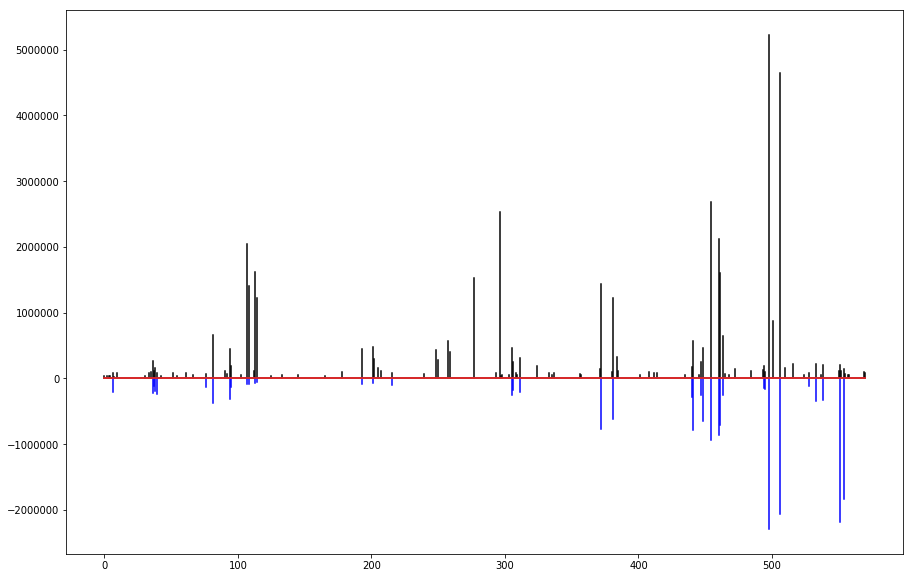

In [62]:
plt.figure(figsize=(15, 10))
plt.stem(np.arange(len(intensity))[unique_mz], intensity[unique_mz], 
        markerfmt=" ",  linefmt="black")

true_select = np.unique(col_index)
false_select = np.unique(decoy_col_index)
true_psuedo = np.matmul(X[:, true_select], solver.coef_[true_select])
false_psuedo = np.matmul(X[:, false_select], solver.coef_[false_select])

plt.stem(np.arange(len(intensity))[unique_mz], -1*np.array(true_psuedo).flatten(),
         markerfmt=" ",  linefmt="blue")
plt.stem(np.arange(len(intensity))[unique_mz], -1*np.array(false_psuedo).flatten(),
         markerfmt=" ",  linefmt="red")
plt.show()

### Checking the number of viable precursors

In [63]:
def count_viable(frame, number):
    ppm_error = 5.
    mz, intensity = frame.get_peaks()
    mass_window = ppm_error * mz * 1e-6 
    overlapping_peaks = np.searchsorted(mz + mass_window, mz - mass_window)
    unique_overlapping = np.unique(overlapping_peaks)
    if unique_overlapping.shape[0] != overlapping_peaks.shape[0]:
        mz = np.array(
            [np.mean(mz[np.where(overlapping_peaks == i)]) for i in unique_overlapping]
        )
        intensity = np.array(
            [np.sum(intensity[np.where(overlapping_peaks == i)]) for i in unique_overlapping]
        )

    mass_window = ppm_error * mz * 1e-6
    intervals = np.sort(np.concatenate([mz - mass_window, mz + mass_window]))
    
    low_rt, high_rt = frame.getRT() + 60 * 5. * np.array([-1., 1.])
    retention_select = np.searchsorted(np.array([low_rt, high_rt]), meta.retention.values) == 1

    pre = frame.getPrecursors()[0]
    low_window, high_window = pre.getMZ() + pre.getIsolationWindowLowerOffset() * np.array([-1. , 1.])
    window_select = np.searchsorted(np.array([low_window, high_window]), meta.precursor) == 1

    select = np.logical_and(retention_select, window_select)

    meta_f = meta[select]

    spec_mz_f = spec_mz[select[spec_isotope]]
    spec_isotope_f = spec_isotope[select[spec_isotope]]
    
    interval_positions = np.searchsorted(intervals, spec_mz_f)
    frag_within_bound = np.mod(interval_positions + 1, 2) == 0

    spec_col_ind = spec_isotope_f[frag_within_bound]
    spec_row_ind = (interval_positions[frag_within_bound] - 1) // 2
    
    return (np.unique(spec_col_ind, return_counts=True)[1] >= 3).sum()

isolation = []
viable_spectra = []
for frame_ind in tqdm(range(30017, 40001)):
    frame = exp[frame_ind]
    if frame.getMSLevel() == 2:
        isolation.append(frame.getPrecursors()[0].getMZ())
        viable_spectra.append(count_viable(frame, 3))

100%|██████████| 9984/9984 [01:18<00:00, 127.30it/s]


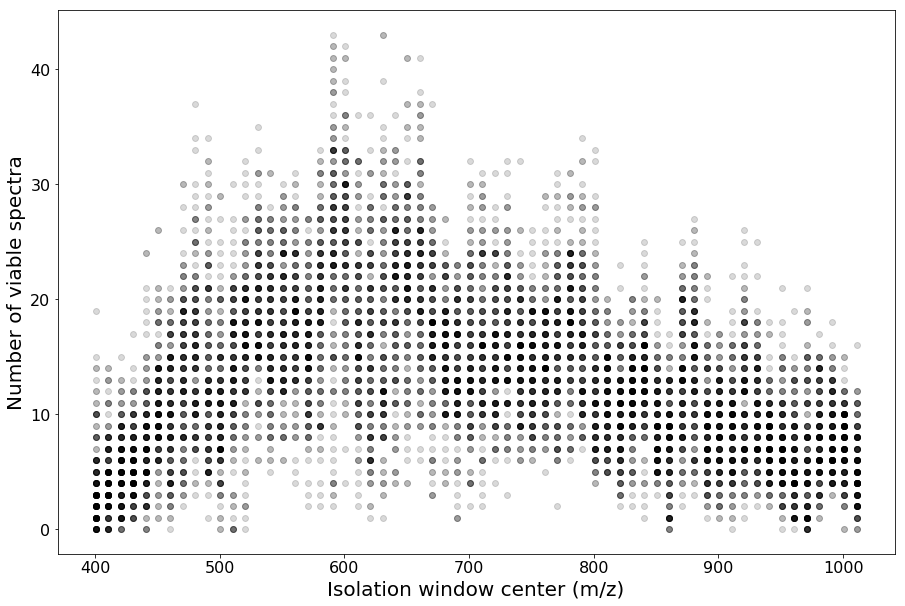

In [69]:
plt.figure(figsize=(15, 10))
plt.scatter(isolation, viable_spectra, alpha=.15, c = "black")
plt.xlabel("Isolation window center (m/z)", size = 20)
plt.ylabel("Number of viable spectra", size = 20)
plt.tick_params(labelsize=16)
plt.show()